In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import shap
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.datasets import make_multilabel_classification
import re
data = pd.read_csv('data_file_csv.csv', encoding = 'cp949')
data

,Unnamed: 0,no,cartype,receipttime,settime,ridetime,startpos1,startpos2,endpos1,endpos2,...,receipt-ride,hour,startlat,startlon,endlat,endlon,whycall,gotoschool,gotocharge,endplus
0,1,8075,중형 승합,2022-05-07 오전 12:08:21,2022-05-07 오전 12:15:19,2022-05-07 오전 12:30:26,영등포구,당산제2동,동작구,신대방제1동,...,22,0,37.53,126.90,37.49,126.90,0,0,0,7469
1,2,8231,중형승합,2022-05-07 오전 12:08:51,2022-05-07 오전 12:17:25,2022-05-07 오전 12:46:23,구로구,신도림동,관악구,남현동,...,38,0,37.50,126.88,37.47,126.97,0,0,0,7469
2,3,8279,중형 승합,2022-05-07 오전 12:09:00,2022-05-07 오전 12:26:57,2022-05-07 오전 12:54:43,노원구,상계3.4동,노원구,하계1동,...,45,0,37.67,127.08,37.64,127.07,0,0,0,7670
3,4,1560,중형 승합,2022-05-07 오전 12:13:00,2022-05-07 오전 12:14:01,2022-05-07 오전 12:14:25,중랑구,상봉제2동,강동구,천호제1동,...,1,0,37.59,127.08,37.54,127.13,0,0,0,7571
4,5,7913,중형승합,2022-05-07 오전 12:18:00,2022-05-07 오전 1:15:54,2022-05-07 오전 1:33:16,중랑구,신내2동,동대문구,전농제3동,...,75,0,37.61,127.09,37.57,127.06,0,0,0,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,2236,3573,중형 승합,2022-05-09 오전 7:00:28,2022-05-09 오전 7:08:36,2022-05-09 오전 7:29:07,강동구,암사제1동,종로구,숭인제2동,...,29,7,37.55,127.13,37.57,127.01,0,0,0,7570
2068,2237,8276,중형 승합,2022-05-09 오전 7:01:00,2022-05-09 오전 7:23:59,2022-05-09 오전 7:38:06,영등포구,영등포동,서대문구,연희동,...,37,7,37.52,126.90,37.57,126.93,0,0,0,7569
2069,2238,3602,중형 승합,2022-05-09 오전 7:01:00,2022-05-09 오전 7:26:08,2022-05-09 오전 7:37:38,구로구,개봉제2동,구로구,구로제5동,...,36,7,37.49,126.85,37.50,126.88,0,0,0,7568
2070,2239,8209,중형승합,2022-05-09 오전 7:01:00,2022-05-09 오전 8:07:22,2022-05-09 오전 8:36:50,강서구,우장산동,마포구,성산제2동,...,95,7,37.54,126.84,37.56,126.90,0,0,0,7569


In [2]:
#이 데이터를 활용하기전에, 문자열 데이터를 숫자 데이터로 변환해줄 필요가 있다.

#딕셔너리에 키 값을 대입해 벨류값을 얻어오는 함수
def get_value(k,dic):
    for key, value in dic.items():
         if k == key:
            return value
        
#string, float등 의사결정나무에서는 사용하기 힘든 변수를 사용할 수 있게끔 만들어주는 함수
def get_index(name):
    temp_list = data[name].tolist()
    temp_set = set(temp_list)
    temp_list2 = list(temp_set)
    dic= {string:i for i,string in enumerate(temp_list2)}
    
    for i in range(len(temp_list)):
        temp = data.loc[i,name]
        temp_value = get_value(temp,dic)
        data.loc[i,name] = temp_value
        

#여기서부터 srartpos1에 있는 string 값들을 전부 숫자로 바꿔주는 작업
get_index('startpos1')
#여기서부터 startpos2에 있는 string 값들을 전부 숫자로 바꿔주는 작업
get_index('startpos2')
#여기서부터 endpos2에 있는 string 값들을 전부 숫자로 바꿔주는 작업
get_index('endpos2')
data.head()

,Unnamed: 0,no,cartype,receipttime,settime,ridetime,startpos1,startpos2,endpos1,endpos2,...,receipt-ride,hour,startlat,startlon,endlat,endlon,whycall,gotoschool,gotocharge,endplus
0,1,8075,중형 승합,2022-05-07 오전 12:08:21,2022-05-07 오전 12:15:19,2022-05-07 오전 12:30:26,11,221,동작구,106,...,22,0,37.53,126.90,37.49,126.90,0,0,0,7469
1,2,8231,중형승합,2022-05-07 오전 12:08:51,2022-05-07 오전 12:17:25,2022-05-07 오전 12:46:23,15,288,관악구,123,...,38,0,37.50,126.88,37.47,126.97,0,0,0,7469
2,3,8279,중형 승합,2022-05-07 오전 12:09:00,2022-05-07 오전 12:26:57,2022-05-07 오전 12:54:43,1,197,노원구,104,...,45,0,37.67,127.08,37.64,127.07,0,0,0,7670
3,4,1560,중형 승합,2022-05-07 오전 12:13:00,2022-05-07 오전 12:14:01,2022-05-07 오전 12:14:25,16,167,강동구,231,...,1,0,37.59,127.08,37.54,127.13,0,0,0,7571
4,5,7913,중형승합,2022-05-07 오전 12:18:00,2022-05-07 오전 1:15:54,2022-05-07 오전 1:33:16,16,87,동대문구,161,...,75,0,37.61,127.09,37.57,127.06,0,0,0,7570


In [3]:
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y = data.iloc[:, 21]
x = data.drop(['Unnamed0', 'no', 'cartype', 'receipttime',
              'settime', 'ridetime', 'startlat',
              'startlon', 'endpos1', 'endpos2',
              'receipt', 'ride', 
               'endlat', 'endlon', 'endplus'], axis = 1)
x['startpos1'] = pd.to_numeric(x['startpos1'])
x['startpos2'] = pd.to_numeric(x['startpos2'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)
print("shape of original dataset :", data.shape)
print("shape of input - training set", x_train.shape)
print("shape of output - training set", y_train.shape)
print("shape of input - testing set", x_test.shape)
print("shape of output - testing set", y_test.shape)
print(x.head())
print(y.head())

shape of original dataset : (2072, 22)
shape of input - training set (1864, 7)
shape of output - training set (1864,)
shape of input - testing set (208, 7)
shape of output - testing set (208,)
   startpos1  startpos2  receiptride  hour  whycall  gotoschool  gotocharge
0         11        221           22     0        0           0           0
1         15        288           38     0        0           0           0
2          1        197           45     0        0           0           0
3         16        167            1     0        0           0           0
4         16         87           75     0        0           0           0
0    7469
1    7469
2    7670
3    7571
4    7570
Name: endplus, dtype: int64


In [4]:
lgb_dtrain = lgb.Dataset(data = x_train, label = y_train)
lgb_param = {
    'learning_rate' : 0.01,
    'n_estimators' : 1000,
    'objective' : 'regression',
    'verbose' : -1
}
lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain)
lgb_model_predict = lgb_model.predict(x_test)
print(
    "RMSE : {}".format(sqrt(mean_squared_error(lgb_model_predict, y_test)))
)

Found `n_estimators` in params. Will use it instead of argument


RMSE : 45.70563488592444


In [5]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(x_test)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1, :], x_test.iloc[1, :])

In [6]:
shap.force_plot(explainer.expected_value, shap_values, x_test)

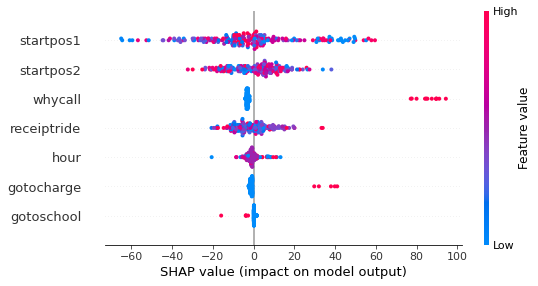

In [7]:
shap.summary_plot(shap_values, x_test)

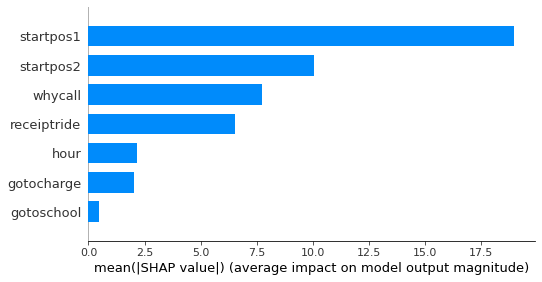

In [8]:
shap.summary_plot(shap_values, x_test, plot_type = 'bar')

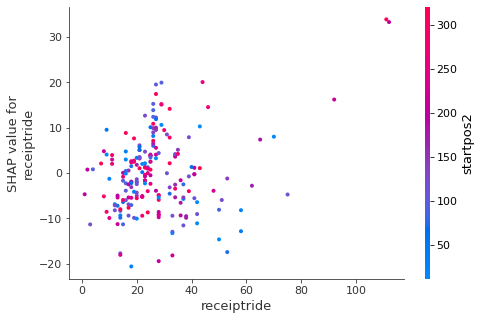

In [9]:
shap.dependence_plot(
    'receiptride', 
    shap_values, 
    x_test
)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


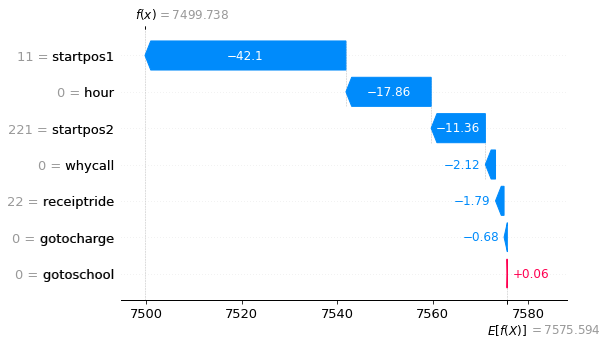

In [10]:
import xgboost

model = xgboost.XGBRegressor().fit(x,y)
explainer = shap.Explainer(model)
shap_values2 = explainer(x)
shap.plots.waterfall(shap_values2[0])

In [11]:
shap.plots.force(shap_values2[0])

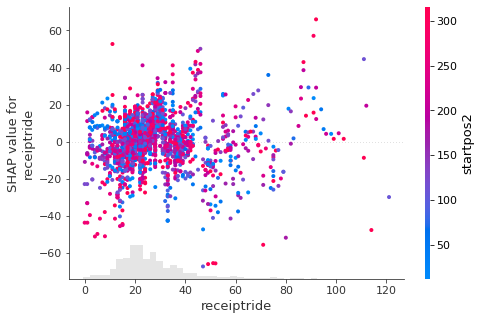

In [12]:
shap.plots.scatter(shap_values2[:, 'receiptride'],
                  color = shap_values2)